# **Bike sharing**

In [1]:
import pandas as pd
from fbprophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR # used to implement Vectorial Auto-Regressive
from statsmodels.stats.stattools import durbin_watson #used to detect the presence of autocorrelation in the residuals
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip

--2020-07-13 12:09:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip.2’

Bike-Sharing-Datase 100%[===================>] 273.43K  --.-KB/s    in 0.1s    

2020-07-13 12:09:30 (1.91 MB/s) - ‘Bike-Sharing-Dataset.zip.2’ saved [279992/279992]



In [3]:
!unzip Bike-Sharing-Dataset.zip

Archive:  Bike-Sharing-Dataset.zip
replace Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Readme.txt              
replace day.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: day.csv                 
replace hour.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hour.csv                


In [4]:
df = pd.read_csv('day.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [5]:
df['dteday'] = pd.to_datetime(df['dteday']) 
df.drop('instant', inplace = True, axis = 1)
df.set_index('dteday', inplace = True)
df['yr'] = df['yr'].astype('category')
df['mnth'] = df['mnth'].astype('category')
df['season'] = df['season'].astype('category')
df['holiday'] = df['holiday'].astype('category')
df['weekday'] = df['weekday'].astype('category')
df['workingday'] = df['workingday'].astype('category')
df['weathersit'] = df['weathersit'].astype('category')

## **Data Exploration**

In [6]:
df.describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


The time series for registered customers present some significant valleys that seem to be outliers.

[]

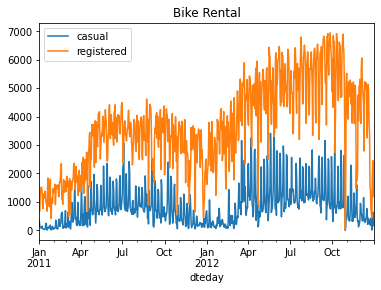

In [7]:
df[['casual','registered']].plot()
plt.title('Bike Rental')
plt.plot()

**#### Rent of casual customers by season and weather situation**

We can observe that during winter the demand for bike is reduced by around 50%. The chart also shows that bad weather implies in less use of the bike service.

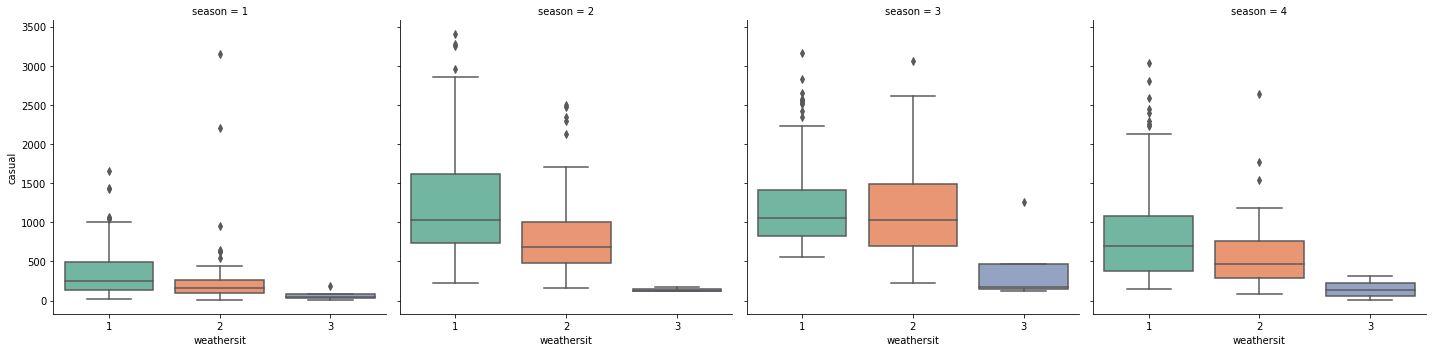

In [8]:
sns.catplot(x="weathersit", y='casual', kind="box", col='season', data=df, palette='Set2')

#### **Rent of registered customers by season and weather situation**

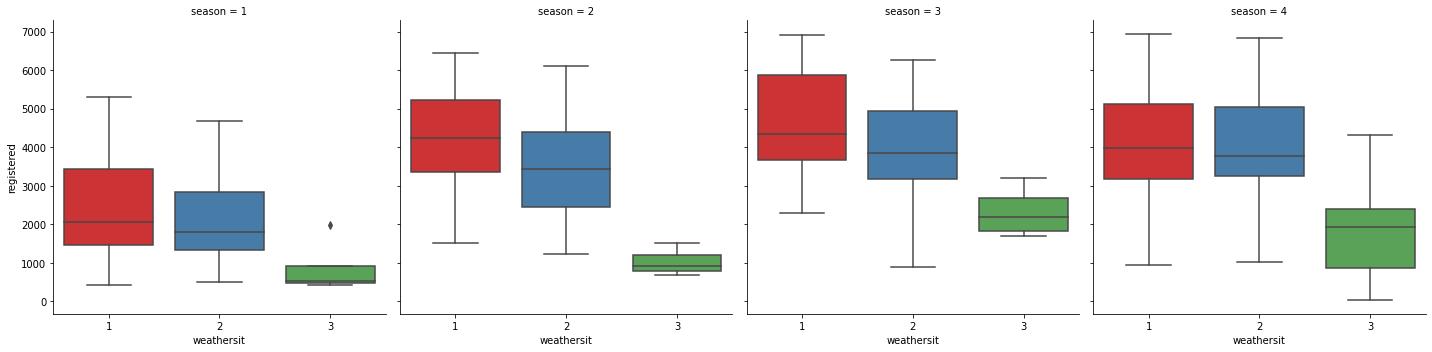

In [9]:
sns.catplot(x="weathersit", y='registered', kind="box", col='season', data=df, palette='Set1')

#### **Rent of customers by working day and weather situation**

It's interesting to notice that the median demand is not impacted by the variable working day for good weather situation. It seems that cycling is a habit for the customers.

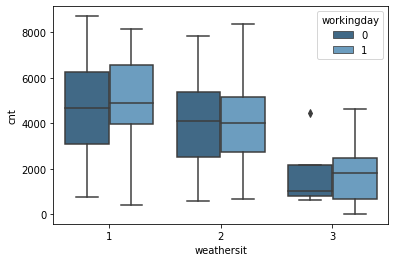

In [10]:
sns.boxplot(x="weathersit", y='cnt', hue = 'workingday', data=df, palette='Blues_d')

#### **Rent of customers by holiday and weather situation**

On the other hand, it seems that during holidays people prefer other activities, once we see a decrease in the median.

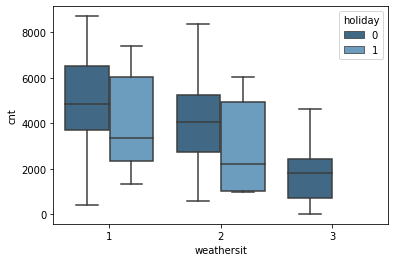

In [11]:
sns.boxplot(x="weathersit", y='cnt', hue = 'holiday', data=df, palette='Blues_d')

The demand grew from 2011 to 2012.

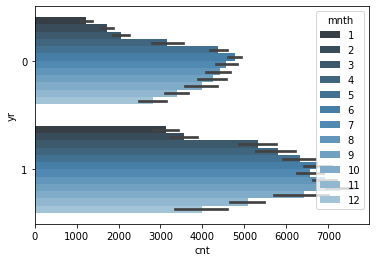

In [12]:
sns.barplot('cnt', y='yr', hue = 'mnth', data=df,  palette='Blues_d')

#### **Checking correlation**

As we would expected there is a high correlation between:
    - temp and atemp
    - registered and cnt

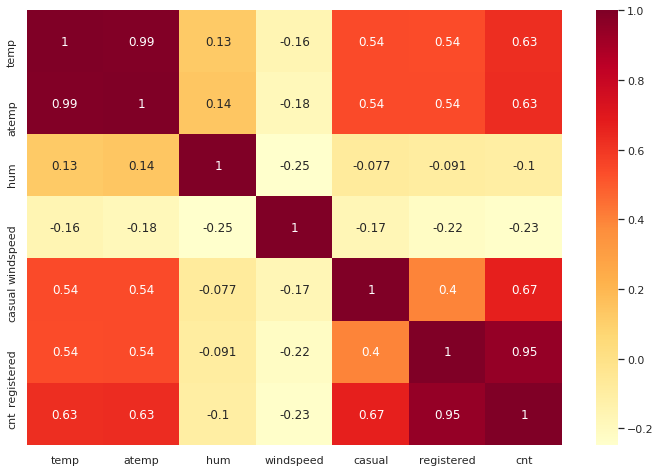

In [13]:
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(df.corr(), annot=True, cmap='YlOrRd')

In [14]:
# Eliminating variables strongly correlated
df.drop(['atemp', 'cnt'], axis = 1, inplace = True)

#### **Checking relationship among numerical variables**

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_rescaled = scaler.fit_transform(df[['temp', 'hum', 'windspeed']])
data_rescaled = pd.DataFrame(data_rescaled, columns = ['temp', 'hum', 'windspeed'], index = df.index)
data_rescaled['casual'] = df.casual
data_rescaled['registered'] = df.registered

The variables do not seem to have a linear relationship with the bike rental.

[]

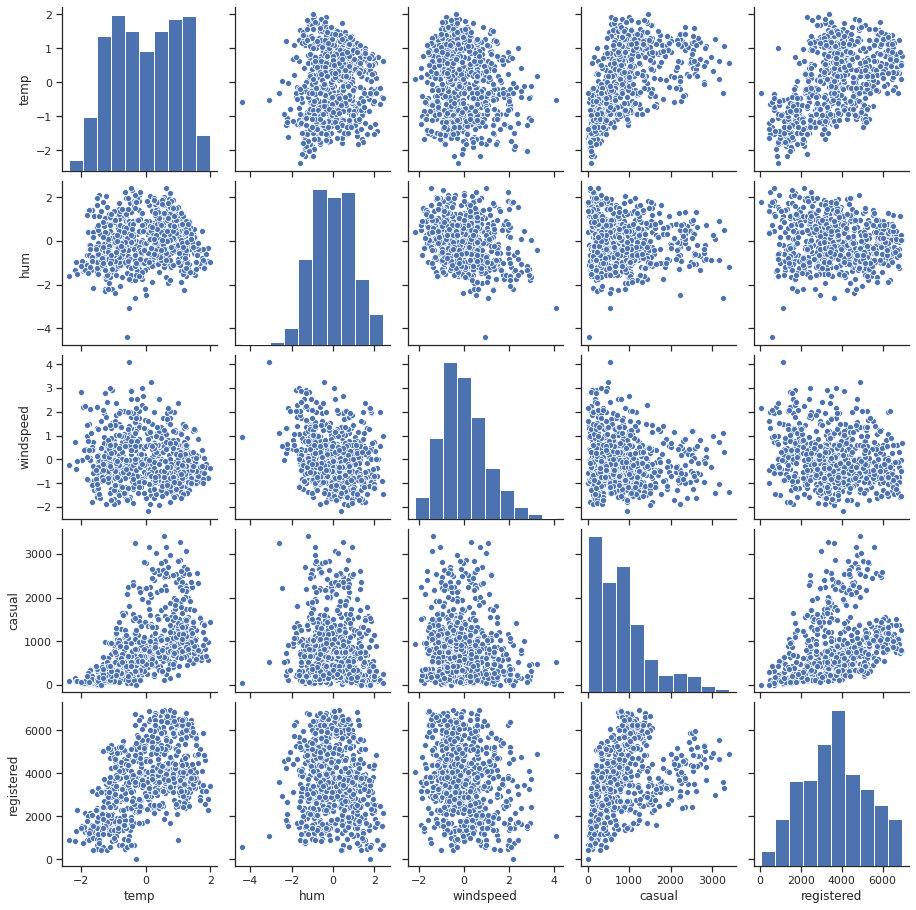

In [16]:
sns.set(style="ticks")
sns.pairplot(data_rescaled)
plt.plot()

During the weekend the median rental of registered customers is smaller than the other days of the week and holidays, whereas for casual customer the pattern is the opposite, having higher rental on weekends and holidays.

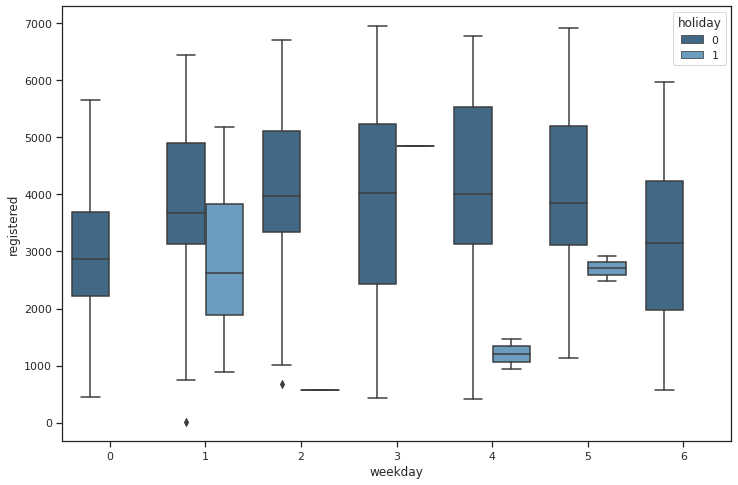

In [17]:
sns.boxplot(data=df, x='weekday', y='registered', hue = 'holiday', palette='Blues_d');

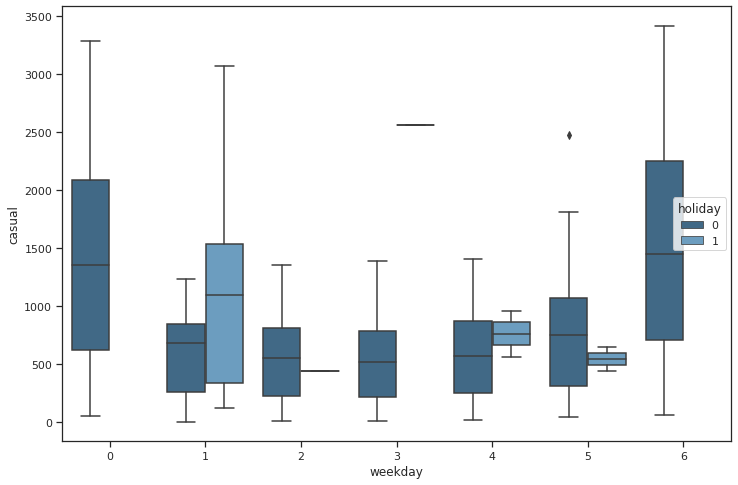

In [18]:
sns.boxplot(data=df, x='weekday', y='casual', hue = 'holiday', palette='Blues_d')

## Analyzing components of the time series

The registered and casual rent of bikes present a growth trend and also annual and weekly seasonality.

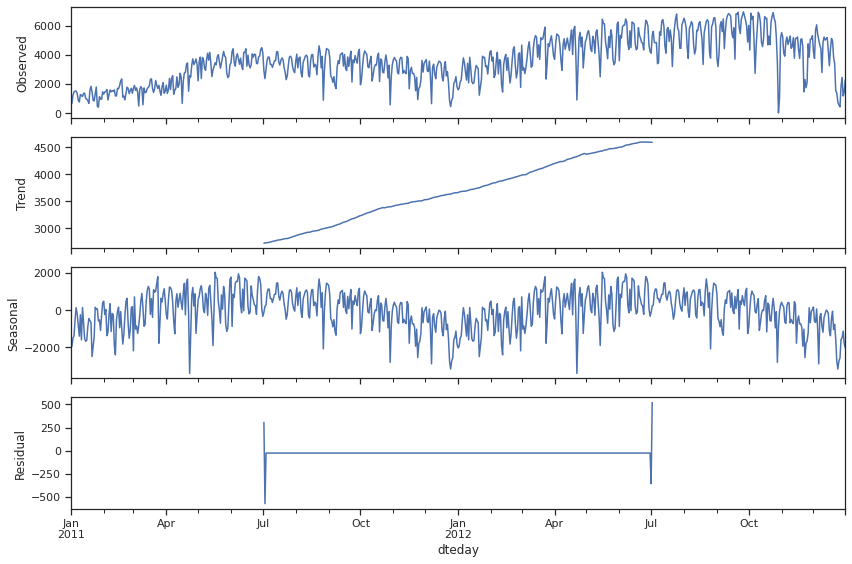

In [19]:
additive_st = seasonal_decompose(df.registered, model='additive', freq=365)
additive_st.plot()
plt.show()

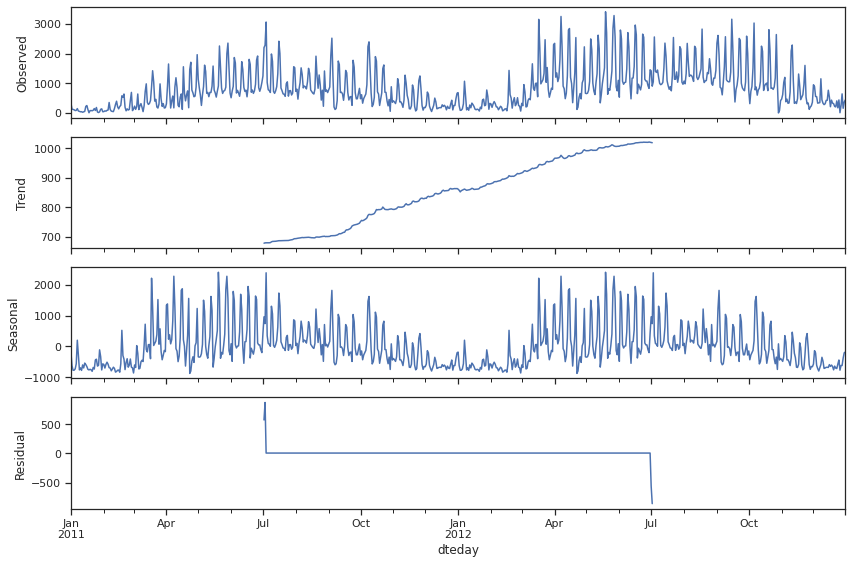

In [20]:
additive_st = seasonal_decompose(df.casual, model='additive', freq=365)
additive_st.plot()
plt.show()

## **Modeling**

<hr>

### <font color ='gray'> **SARIMAX**</font>

In [21]:
# Splitting into train and test, separating three months to test
n = datetime(2012,9,30)
df_train = df[:n]
df_test = df[n + timedelta(days=1):]

#### **Registered Customers**

In [22]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(df.registered,regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.9858850388386026


In [66]:
2#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(df.registered.diff(2).dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:1.3659463831805558e-14


Removing by differencing trend and seasonality, we see that we still have a weekly seasonality

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



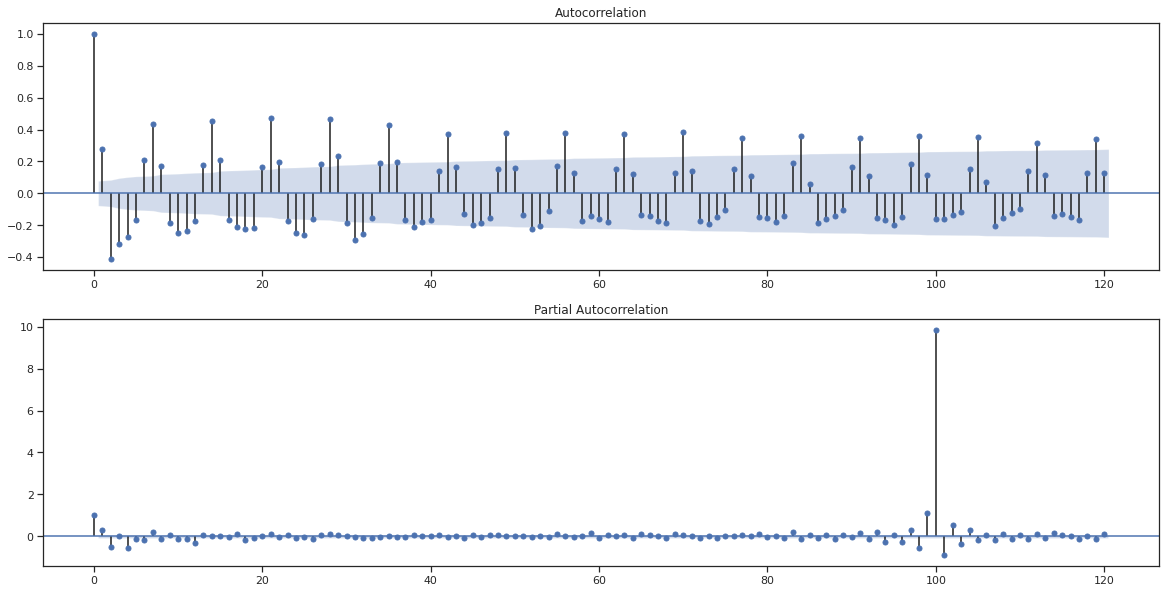

In [56]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df_train.registered.diff(2).dropna(), lags=120, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df_train.registered.diff(2).dropna(), lags=120, ax=ax[1])
plt.show()

In [25]:
resDiff = sm.tsa.arma_order_select_ic(df_train.registered, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: Hessia

ARMA(p,q) = (7, 7) is the best.


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [57]:
features = df_train.drop(['casual','registered'], axis = 1)
features = pd.get_dummies(features)

# As we have two seasonalities let's try to capture them using the features of the dataset
sarimax = sm.tsa.statespace.SARIMAX(df_train.registered, order=(7,2,7), exog = features, freq='D', enforce_stationarity=False, enforce_invertibility=False).fit()
sarimax.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             registered   No. Observations:                  639
Model:               SARIMAX(7, 2, 7)   Log Likelihood               -4830.458
Date:                Mon, 13 Jul 2020   AIC                           9760.916
Time:                        13:02:29   BIC                           9983.122
Sample:                    01-01-2011   HQIC                          9847.233
                         - 09-30-2012                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
temp          3467.3161    396.098      8.754      0.000    2690.977    4243.655
hum          -1660.4916    181.690     -9.139      0.000   -2016.597   -1304.386
windspeed    -1020.2029    289.890     -3.519      0.000   -1588.376    -452.029
season_1      -377.2072   2322.762     -0.162      0.871   -4929.737    4175.323
season_2        -1.6025   2325.567     -0.001      0.999   -4559.630    4556.425
season_3       849.9810   2315.214      0.367      0.714   -3687.756    5387.717
season_4      -471.1713   2331.323     -0.202      0.840   -5040.480    4098.138
yr_0          1735.7187   4637.825      0.374      0.708   -7354.251    1.08e+04
yr_1         -1735.7187   5033.034     -0.345      0.730   -1.16e+04    8128.847
mnth_1        1370.5682   1350.651      1.015      0.310   -1276.660    4017.796
mnth_2        1193.1883   1023.389      1.166      0.244    -812.617    3198.994
mnth_3        2812.1361   1055.128      2.665      0.008     744.123    4880.149
mnth_4        1783.6441   1035.888      1.722      0.085    -246.660    3813.948
mnth_5        1009.4653   1028.353      0.982      0.326   -1006.069    3024.999
mnth_6          30.1862   1031.507      0.029      0.977   -1991.531    2051.904
mnth_7        -560.7372   1062.571     -0.528      0.598   -2643.338    1521.863
mnth_8        -395.2633   1132.126     -0.349      0.727   -2614.189    1823.663
mnth_9        -717.1601   1149.608     -0.624      0.533   -2970.350    1536.030
mnth_10      -1922.5721   1198.409     -1.604      0.109   -4271.411     426.266
mnth_11      -2106.4402   1785.197     -1.180      0.238   -5605.362    1392.482
mnth_12      -2497.0154   1847.802     -1.351      0.177   -6118.641    1124.611
holiday_0      -19.2967   5183.023     -0.004      0.997   -1.02e+04    1.01e+04
holiday_1       19.2967   4082.058      0.005      0.996   -7981.389    8019.983
weekday_0     -247.3671    547.056     -0.452      0.651   -1319.577     824.843
weekday_1      -61.6131   1633.644     -0.038      0.970   -3263.497    3140.271
weekday_2      120.6719   1626.769      0.074      0.941   -3067.738    3309.081
weekday_3      127.7718   1629.666      0.078      0.938   -3066.316    3321.859
weekday_4      116.1243   1642.520      0.071      0.944   -3103.155    3335.404
weekday_5       26.8142   1640.482      0.016      0.987   -3188.472    3242.100
weekday_6      -82.4020    553.236     -0.149      0.882   -1166.725    1001.921
workingday_0  -310.4724   5178.227     -0.060      0.952   -1.05e+04    9838.666
workingday_1   310.4724   4086.300      0.076      0.939   -7698.528    8319.473
weathersit_1   484.5276   3088.791      0.157      0.875   -5569.392    6538.447
weathersit_2   245.6431   3084.039      0.080      0.937   -5798.963    6290.249
weathersit_3  -730.1707   3092.769     -0.236      0.813   -6791.887    5331.545
ar.L1           -0.6892      0.513     -1.343      0.179      -1.695       0.317
ar.L2           -0.7869      0.535     -1.471      0.141      -1.836       0.262
a

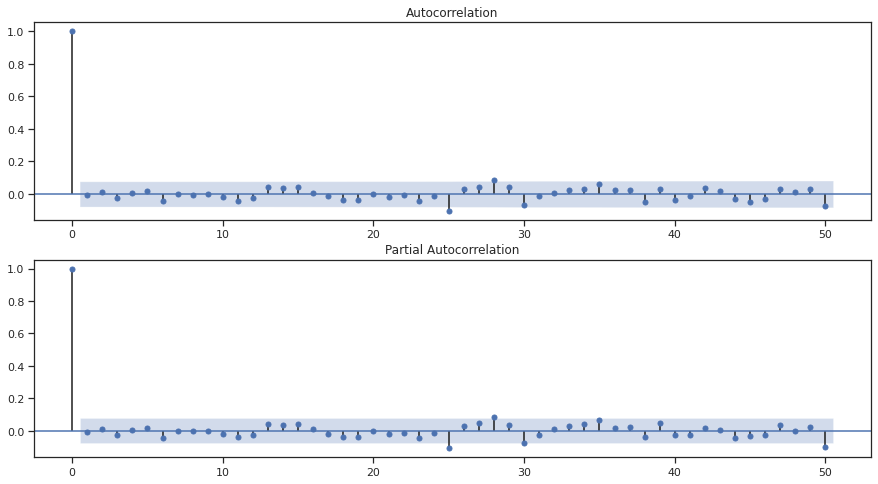

In [58]:
res = sarimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

The Normal Q-Q plot shows that we have some problems to assure the homoscedascity of residuals, what is sign that the quality of our model will be poor. On the residuals we also have 

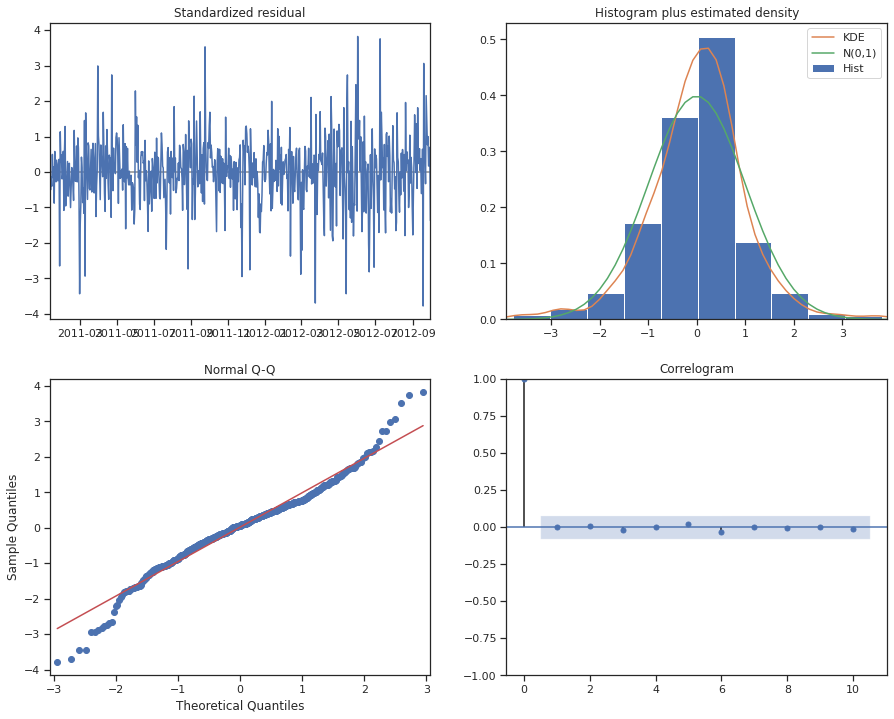

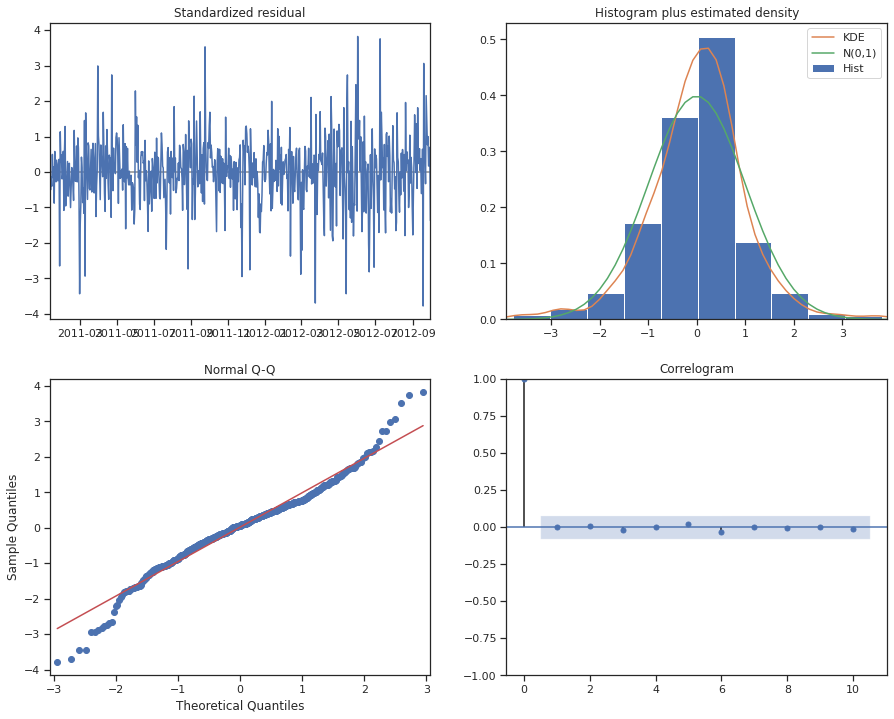

In [59]:
sarimax.plot_diagnostics(figsize=(15, 12))

SARIMAX model MSE:1871653.641470072


[]

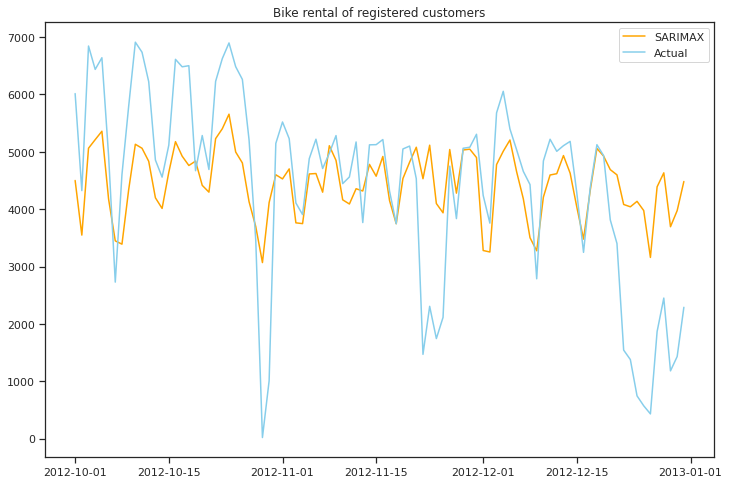

In [60]:
features = df_test.drop(['casual','registered'], axis = 1)
features = pd.get_dummies(features)

pred = sarimax.predict(df_train.index[-1], df_test.index[-1], exog = features)[1:]
print('SARIMAX model MSE:{}'.format(mean_squared_error(df_test.registered, pred)))
plt.plot(pred, color ='orange', label='SARIMAX')
plt.plot(df_test.registered, color='skyblue', label ='Actual')
plt.title('Bike rental of registered customers')
plt.legend()
plt.plot()

#### **Casual Customers**

In [30]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(df.casual,regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.9091092883989833


In [67]:
#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(df.casual.diff(2).dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:2.20407665077324e-11


Removing by differencing trend and seasonality, we see that we still have a weekly seasonality

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



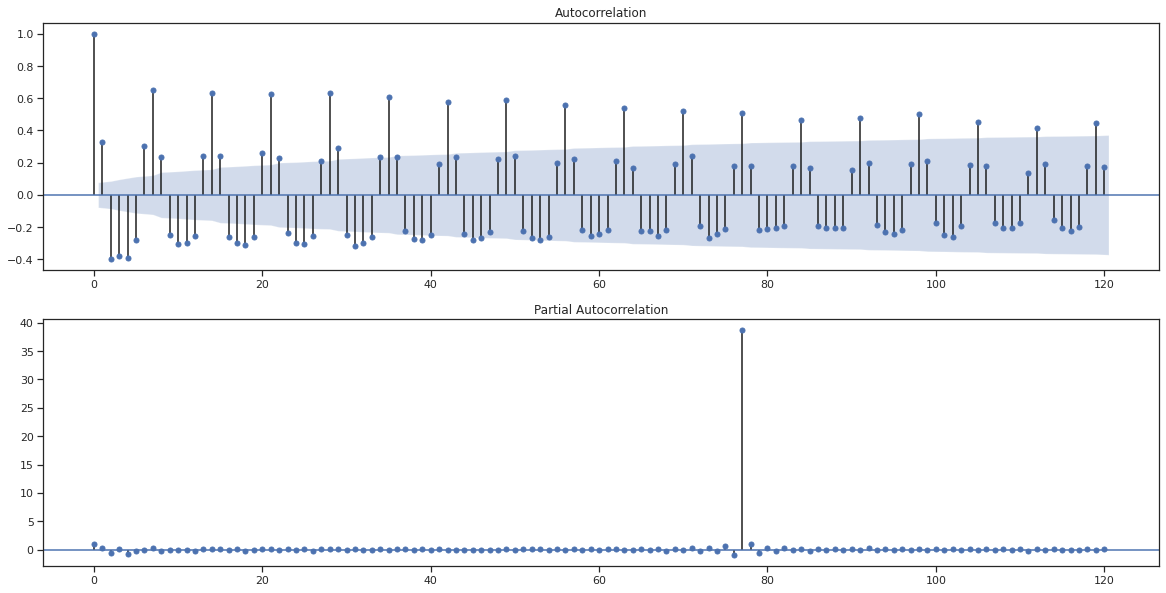

In [54]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df_train.casual.diff(2).dropna(), lags=120, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df_train.casual.diff(2).dropna(), lags=120, ax=ax[1])
plt.show()

In [33]:
resDiff = sm.tsa.arma_order_select_ic(df_train.casual, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/t

ARMA(p,q) = (6, 5) is the best.


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [61]:
features = df_train.drop(['casual','registered'], axis = 1)
features = pd.get_dummies(features)

sarimax = sm.tsa.statespace.SARIMAX(df_train.casual, order=(6,2,5),
                                   exog = features, freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
sarimax.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                 casual   No. Observations:                  639
Model:               SARIMAX(6, 2, 5)   Log Likelihood               -4532.832
Date:                Mon, 13 Jul 2020   AIC                           9159.664
Time:                        13:04:26   BIC                           9368.687
Sample:                    01-01-2011   HQIC                          9240.848
                         - 09-30-2012                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
temp          1948.5885    291.786      6.678      0.000    1376.699    2520.478
hum           -653.4891    157.949     -4.137      0.000    -963.063    -343.915
windspeed     -828.6800    207.167     -4.000      0.000   -1234.720    -422.640
season_1       -44.4256    671.462     -0.066      0.947   -1360.468    1271.616
season_2        77.7657    678.930      0.115      0.909   -1252.912    1408.443
season_3       140.1447    680.848      0.206      0.837   -1194.292    1474.582
season_4      -173.4848    690.632     -0.251      0.802   -1527.099    1180.130
yr_0          1148.3260   1363.770      0.842      0.400   -1524.613    3821.265
yr_1         -1148.3261   1643.550     -0.699      0.485   -4369.624    2072.972
mnth_1        1607.7243    553.959      2.902      0.004     521.985    2693.463
mnth_2        1281.6456    471.780      2.717      0.007     356.973    2206.318
mnth_3        1073.4783    408.895      2.625      0.009     272.059    1874.897
mnth_4         638.9098    383.055      1.668      0.095    -111.865    1389.684
mnth_5         265.3091    342.168      0.775      0.438    -405.327     935.945
mnth_6        -163.9085    335.078     -0.489      0.625    -820.650     492.833
mnth_7        -410.4775    348.532     -1.178      0.239   -1093.587     272.632
mnth_8        -386.8057    402.064     -0.962      0.336   -1174.837     401.225
mnth_9        -321.2042    450.868     -0.712      0.476   -1204.888     562.480
mnth_10      -1136.6478    525.910     -2.161      0.031   -2167.413    -105.882
mnth_11      -1184.8540    967.826     -1.224      0.221   -3081.758     712.050
mnth_12      -1263.1695   1044.437     -1.209      0.226   -3310.229     783.890
holiday_0      111.9822   1498.764      0.075      0.940   -2825.542    3049.506
holiday_1     -111.9823   1179.566     -0.095      0.924   -2423.889    2199.924
weekday_0      142.7471    164.752      0.866      0.386    -180.160     465.654
weekday_1      -36.6980    488.118     -0.075      0.940    -993.392     919.996
weekday_2     -125.9319    486.366     -0.259      0.796   -1079.192     827.328
weekday_3     -125.7962    476.450     -0.264      0.792   -1059.622     808.030
weekday_4     -137.5421    465.791     -0.295      0.768   -1050.476     775.391
weekday_5       32.4198    465.245      0.070      0.944    -879.443     944.283
weekday_6      250.8012    160.410      1.564      0.118     -63.596     565.198
workingday_0   281.5660   1497.093      0.188      0.851   -2652.683    3215.815
workingday_1  -281.5661   1180.711     -0.238      0.812   -2595.717    2032.585
weathersit_1   173.5565    890.843      0.195      0.846   -1572.463    1919.576
weathersit_2    89.5121    890.411      0.101      0.920   -1655.662    1834.686
weathersit_3  -263.0687    898.700     -0.293      0.770   -2024.488    1498.350
ar.L1           -0.5206      0.753     -0.692      0.489      -1.996       0.955
ar.L2           -0.4063      0.190     -2.142      0.032      -0.778      -0.035
a

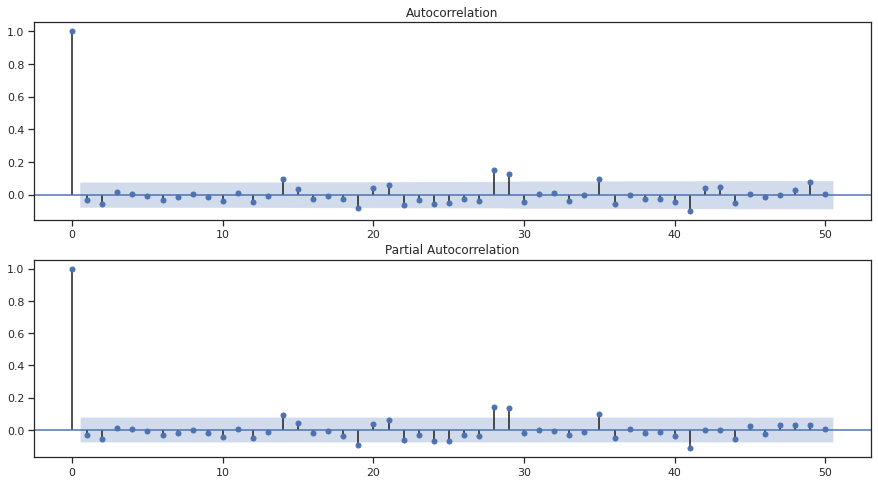

In [62]:
res = sarimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

The Normal Q-Q plot shows that we have some problems to assure the homoscedascity of residuals, what is sign that the quality of our model will be poor. On the residuals we also have 

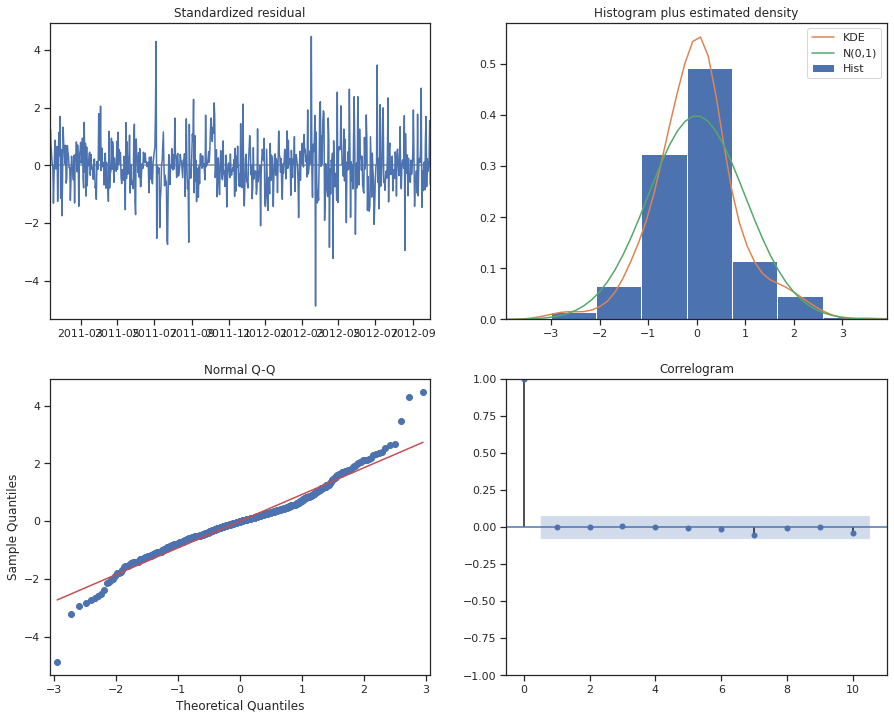

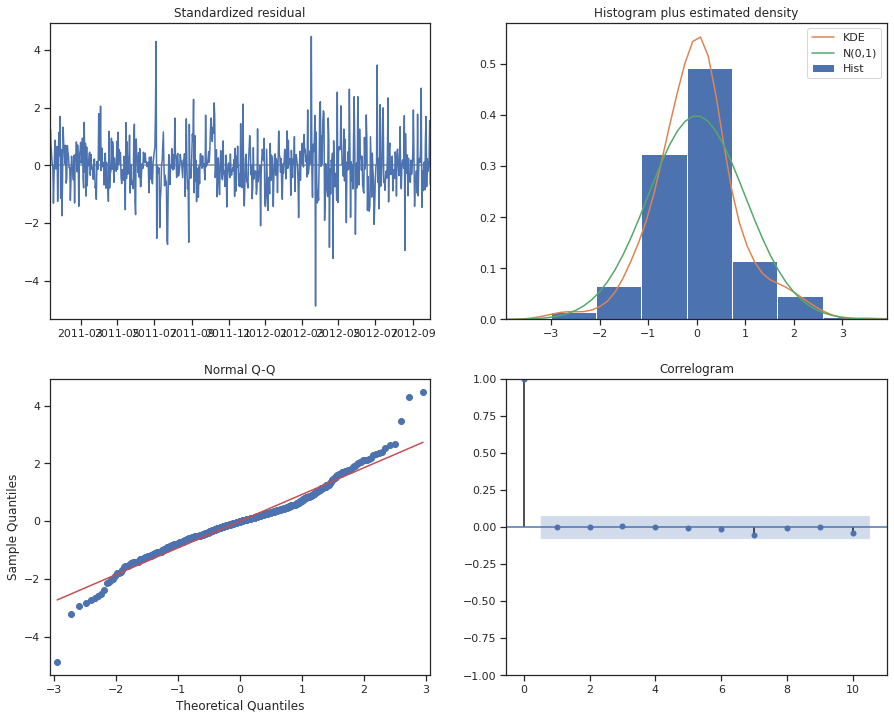

In [63]:
sarimax.plot_diagnostics(figsize=(15, 12))

SARIMAX model MSE:348846.0976263111


[]

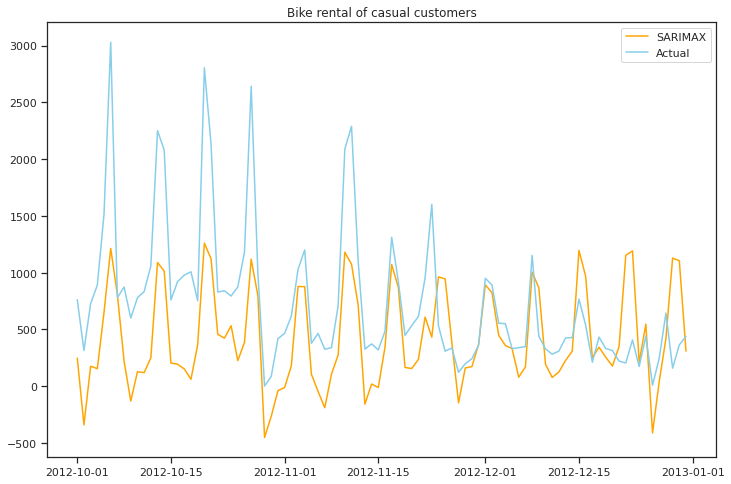

In [64]:
features = df_test.drop(['casual','registered'], axis = 1)
features = pd.get_dummies(features)

pred = sarimax.predict(df_train.index[-1], df_test.index[-1], exog = features)[1:]
print('SARIMAX model MSE:{}'.format(mean_squared_error(df_test.casual, pred)))
plt.plot(pred, color ='orange', label='SARIMAX')
plt.plot(df_test.casual, color='skyblue', label ='Actual')
plt.title('Bike rental of casual customers')
plt.legend()
plt.plot()

## **<font color ='gray'> Prophet</font>**

#### **Registered Customers** <hr>

In [39]:
df_sel = df_train[['season', 'holiday', 'weekday','workingday', 'weathersit', 'temp', 'hum', 'windspeed','registered']].copy()
df_sel.reset_index(inplace = True)
df_sel.rename(columns={"registered": "y", "dteday" :"ds"}, inplace=True)

In [40]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=0.01, seasonality_mode='multiplicative')
m.add_seasonality(name='weekly', period=7, fourier_order=5)
m.add_seasonality(name='yearly', period=365, fourier_order=5)
m.add_regressor('season')
m.add_regressor('holiday')
m.add_regressor('weekday')
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('hum')
m.add_regressor('windspeed')
forecast = m.fit(df_sel)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
period = df_test.shape[0]
future = m.make_future_dataframe(periods=period)
future = future.merge(df_test[['season', 'holiday', 'weekday','workingday', 'weathersit', 'temp', 'hum', 'windspeed']], left_on='ds', right_on='dteday')

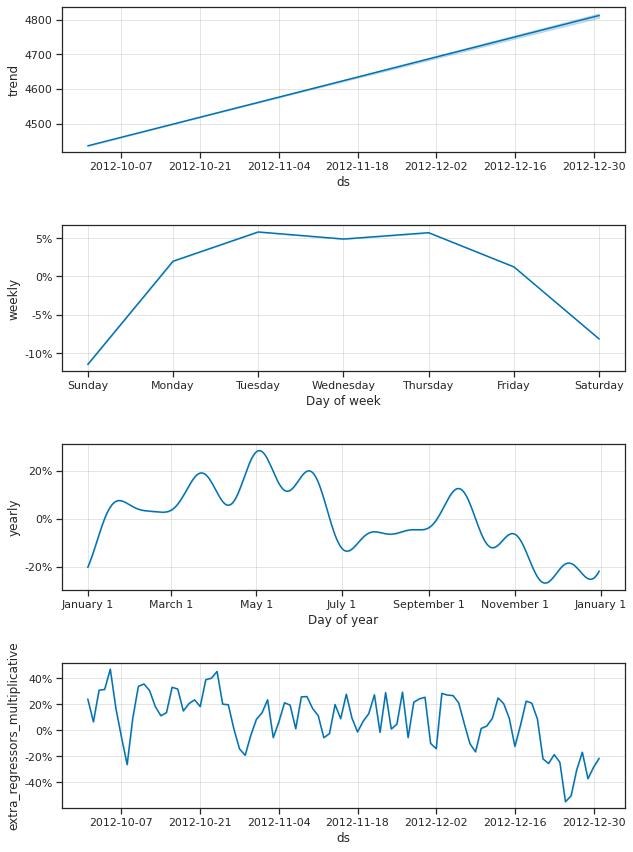

In [42]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

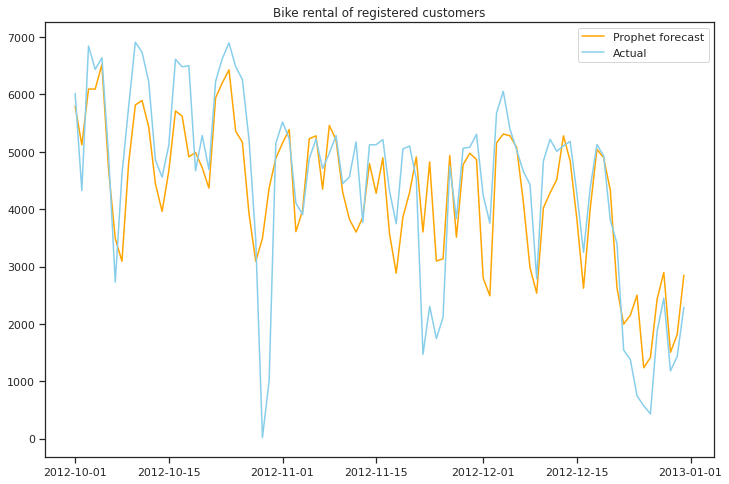

Prophet model MSE:877199.6201699695


In [43]:
plt.plot(df_test.index,forecast.yhat, color ='orange', label ='Prophet forecast')
plt.plot(df_test.index,df_test.registered, color = 'skyblue', label ='Actual')
plt.title('Bike rental of registered customers')
plt.legend()
plt.show()

print('Prophet model MSE:{}'.format(mean_squared_error(df_test.registered, forecast.yhat)))

In [44]:
import numpy as np
np.sqrt(877199.6201699695)

936.5893551444889

### **Casual**
<hr>

In [45]:
df_sel = df_train[['season', 'holiday', 'weekday','workingday', 'weathersit', 'temp', 'hum', 'windspeed','casual']].copy()
df_sel.reset_index(inplace = True)
df_sel.rename(columns={"casual": "y", "dteday" :"ds"}, inplace=True)

In [46]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=0.01, seasonality_mode='additive')
m.add_seasonality(name='weekly', period=7, fourier_order=5)
m.add_seasonality(name='yearly', period=365, fourier_order=5)
m.add_regressor('season')
m.add_regressor('holiday')
m.add_regressor('weekday')
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('hum')
m.add_regressor('windspeed')
forecast = m.fit(df_sel)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
period = df_test.shape[0]
future = m.make_future_dataframe(periods=period)
future = future.merge(df_test[['season', 'holiday', 'weekday','workingday', 'weathersit', 'temp', 'hum', 'windspeed']], left_on='ds', right_on='dteday')

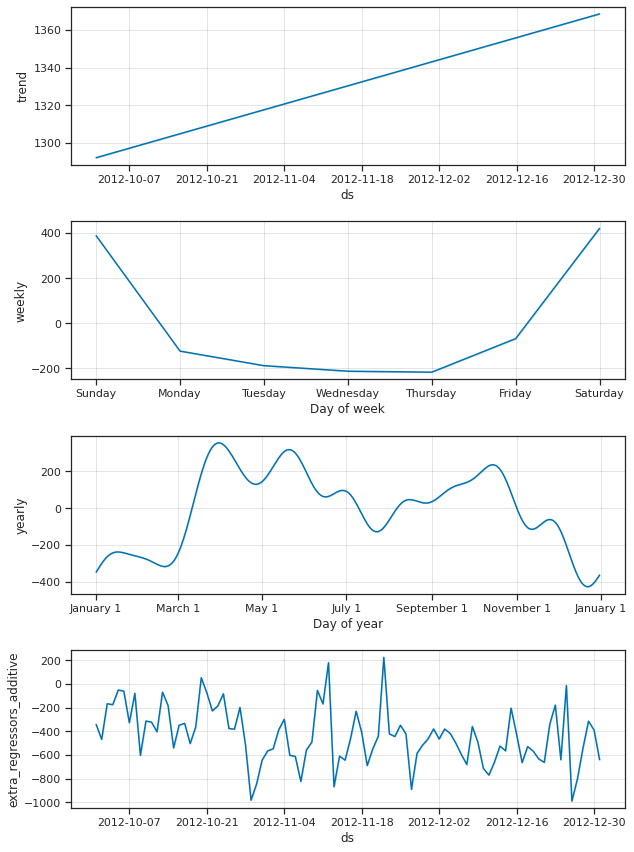

In [48]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

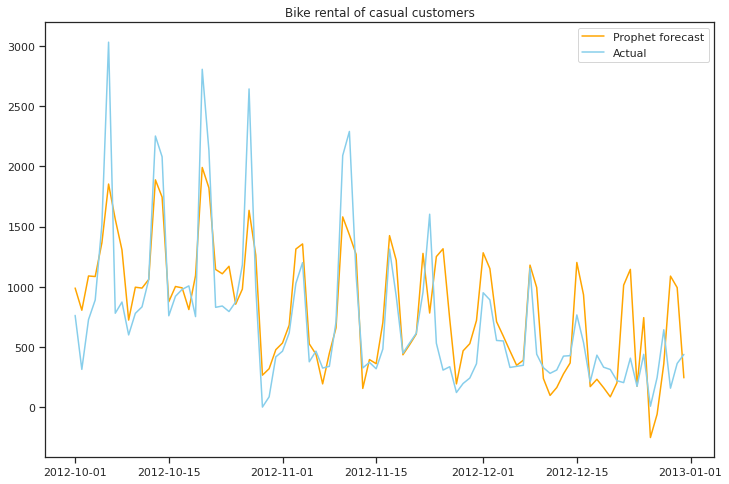

Prophet model MSE:15698853.901440801


In [49]:
plt.plot(df_test.index,forecast.yhat, color ='orange', label ='Prophet forecast')
plt.plot(df_test.index,df_test.casual, color = 'skyblue', label ='Actual')
plt.title('Bike rental of casual customers')
plt.legend()
plt.show()

print('Prophet model MSE:{}'.format(mean_squared_error(df_test.registered, forecast.yhat)))